In [7]:
# Descriptive statistics table (reads Market Cap from CSV files and includes Unit Root)
import os
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# -------- config --------
DATA_DIR = r"C:\Users\cooki\OneDrive\Uni\Seminar Econ in financial application\by_ticker_csv"
TICKERS = ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY', 'GILD', 'GSK','JNJ', 'LLY', 'MRK', 'NVO', 'NVS', 'PFE', 'RHHBY', 'SNY']
SAVE_CSV = "descriptive_stats_with_unitroot_mcap.csv"  # optional output file

# -------- helpers --------
def load_one(ticker):
    """Load one ticker's CSV, compute daily returns (in %) and get latest market cap."""
    path = os.path.join(DATA_DIR, f"{ticker}.csv")
    df = pd.read_csv(path, parse_dates=["Date"]).sort_values("Date")
    
    if "Close" not in df.columns:
        raise ValueError(f"{ticker}.csv missing 'Close' column")
    df["Adj Close"] = df["Close"]
    df["ret"] = df["Adj Close"].pct_change() * 100  # daily return in %
    df["Ticker"] = ticker

    # find market cap column (case-insensitive)
    mcap_col = next((col for col in df.columns if col.lower() in ["marketcap", "mcap", "market_cap"]), None)
    if mcap_col:
        # take the most recent valid value
        latest_mcap = df[mcap_col].dropna().iloc[-1]
    else:
        latest_mcap = np.nan

    return df[["Date","Ticker","ret"]], latest_mcap

# -------- load all tickers --------
rets_list = []
market_caps = {}

for t in TICKERS:
    df, mcap = load_one(t)
    rets_list.append(df)
    market_caps[t] = mcap

rets = pd.concat(rets_list, ignore_index=True)
daily_pct_change = rets.pivot(index="Date", columns="Ticker", values="ret").dropna()

# -------- descriptive stats --------
stats = daily_pct_change.describe().T.rename(
    columns={"count":"Obs","mean":"Mean","std":"σ","min":"Min","max":"Max"}
)[["Obs","Mean","σ","Min","Max"]].round(3)

# -------- ADF Unit Root Test --------
unit_root_results = {}
for ticker in daily_pct_change.columns:
    try:
        adf_stat, pval, *_ = adfuller(daily_pct_change[ticker].dropna(), autolag='AIC')
        stars = "***" if pval < 0.01 else "**" if pval < 0.05 else "*" if pval < 0.1 else ""
        unit_root_results[ticker] = f"{adf_stat:.2f}{stars}"
    except Exception as e:
        unit_root_results[ticker] = np.nan

stats["Unit root"] = stats.index.map(unit_root_results)

# -------- Market Cap --------
stats["Mcap"] = stats.index.map(market_caps)

# -------- reorder & sort --------
stats = stats[["Obs","Mean","σ","Min","Max","Unit root","Mcap"]]
stats = stats.sort_values(by="Mcap", ascending=False)

# -------- display formatted table --------
styled = (
    stats.style
    .format({
        "Mcap": "{:,.0f}",
        "Mean": "{:.2f}",
        "σ": "{:.2f}",
        "Min": "{:.2f}",
        "Max": "{:.2f}"
    })
    .set_caption("Table: Descriptive statistics for the daily returns of the assets (in %)")
    .set_table_styles([
        {"selector": "caption", "props": [("font-size", "13px"), ("font-weight", "bold"), ("text-align", "center")]}
    ])
)

display(styled)

if SAVE_CSV:
    stats.to_csv(SAVE_CSV, index_label="Ticker")
    print(f"✅ Saved table with unit root and market cap to: {SAVE_CSV}")


,Obs,Mean,σ,Min,Max,Unit root,Mcap
Ticker,,,,,,,
LLY,2515.000000,0.11,1.76,-10.52,15.68,-16.44***,"692,064,617,948"
JNJ,2515.000000,0.02,1.14,-10.04,8.00,-16.32***,"348,293,955,909"
ABBV,2515.000000,0.05,1.69,-16.25,13.77,-12.26***,"313,917,396,167"
NVO,2515.000000,0.07,1.77,-17.83,17.23,-51.94***,"289,763,351,293"
MRK,2515.000000,0.03,1.36,-9.86,10.41,-16.97***,"248,479,482,215"
AZN,2515.000000,0.04,1.55,-14.91,9.29,-16.91***,"203,146,007,969"
RHHBY,2515.000000,0.01,1.35,-9.10,13.01,-17.70***,"192,433,292,928"
NVS,2515.000000,0.01,1.21,-9.82,8.00,-18.31***,"188,377,868,998"
PFE,2515.000000,0.01,1.47,-7.74,10.86,-11.03***,"150,837,658,669"


✅ Saved table with unit root and market cap to: descriptive_stats_with_unitroot_mcap.csv


Saved: daily_returns_grid_all_years.png


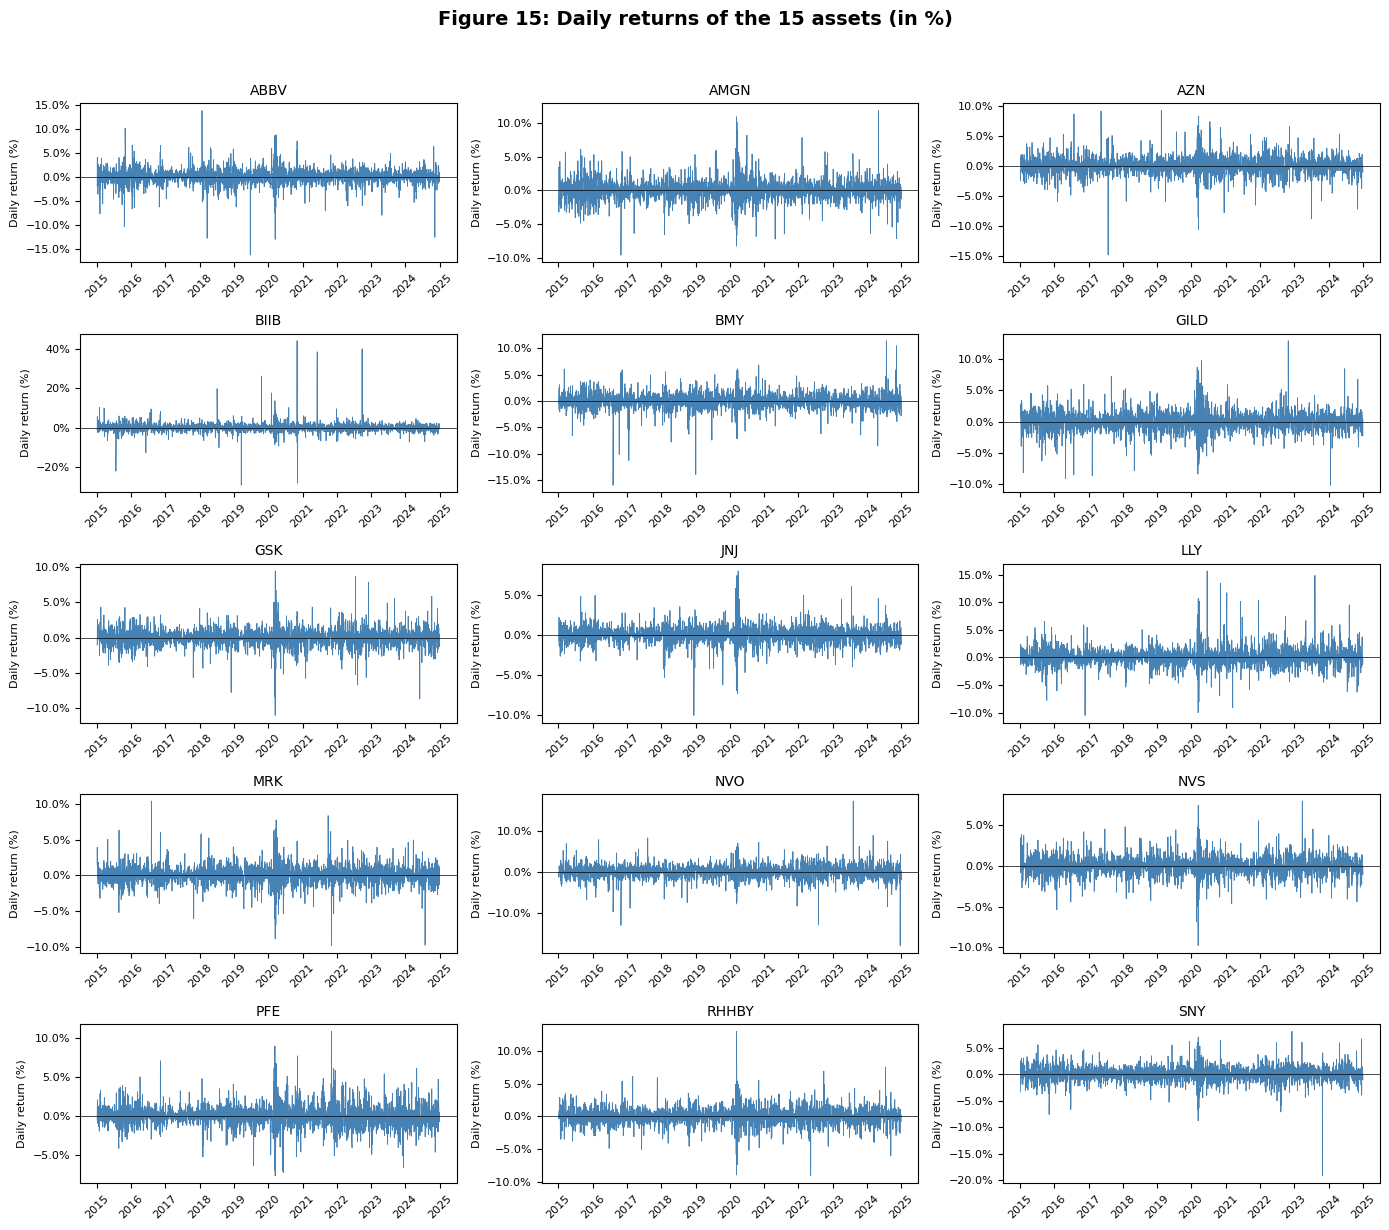

In [5]:
# Daily returns subplots (percent version)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter

# -------- config --------
DATA_DIR = r"C:\Users\cooki\OneDrive\Uni\Seminar Econ in financial application\by_ticker_csv"
TICKERS = ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY', 'GILD', 'GSK', 'JNJ', 'LLY', 'MRK', 'NVO', 'NVS', 'PFE', 'RHHBY', 'SNY']
SAVE_PNG = "daily_returns_grid_all_years.png"

# -------- helpers --------
def list_tickers(path):
    if not os.path.isdir(path):
        raise FileNotFoundError(f"Data directory not found: {path}")
    return sorted(os.path.splitext(f)[0] for f in os.listdir(path) if f.lower().endswith(".csv"))

def load_one(ticker):
    df = pd.read_csv(os.path.join(DATA_DIR, f"{ticker}.csv"), parse_dates=["Date"]).sort_values("Date")
    if "Close" not in df.columns:
        raise ValueError(f"{ticker}.csv missing 'Close' column")
    # if you don't have adjusted prices, mirror Close
    df["Adj Close"] = df["Close"]
    # convert to PERCENT returns
    df["ret_pct"] = df["Adj Close"].pct_change() * 100.0
    df["Ticker"] = ticker
    return df[["Date","Ticker","ret_pct"]]

# -------- compute returns --------
tickers = TICKERS or list_tickers(DATA_DIR)
rets = pd.concat([load_one(t) for t in tickers], ignore_index=True)
daily_ret_pct = rets.pivot(index="Date", columns="Ticker", values="ret_pct").sort_index()

# -------- grid setup --------
n = len(daily_ret_pct.columns)
n_cols = 3
n_rows = int(np.ceil(n / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 2.5), sharex=False)
axes = np.atleast_1d(axes).ravel()

# -------- plot --------
for i, t in enumerate(daily_ret_pct.columns):
    ax = axes[i]
    ax.plot(daily_ret_pct.index, daily_ret_pct[t], linewidth=0.6, color="steelblue")
    ax.axhline(0, color="black", linewidth=0.5)
    ax.set_title(t, fontsize=10)
    ax.set_ylabel("Daily return (%)", fontsize=8)

    # x-axis formatting
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.tick_params(axis="x", rotation=45, labelsize=8)
    ax.tick_params(axis="y", labelsize=8)

    # y-axis in percent (values already in -5 to +5 etc.)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Figure 15: Daily returns of the 15 assets (in %)", fontsize=14, fontweight="bold")
fig.tight_layout(rect=[0, 0, 1, 0.96])

if SAVE_PNG:
    fig.savefig(SAVE_PNG, dpi=200, bbox_inches="tight")
    print(f"Saved: {SAVE_PNG}")

plt.show()
